### This loads some support codes I've written

In [1]:
%%shell
git clone https://code.ornl.gov/nmp/eds_montage.git

Cloning into 'eds_montage'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 286 (delta 72), reused 98 (delta 59), pack-reused 170
Receiving objects: 100% (286/286), 56.17 MiB | 8.84 MiB/s, done.
Resolving deltas: 100% (173/173), done.


### Some non-standard packages we need

In [2]:
!pip install pycroscopy
!pip install pyUSID
!pip install matplotlib-scalebar


     |████████████████████████████████| 348 kB 8.1 MB/s 
     |████████████████████████████████| 51 kB 277 kB/s 
     |████████████████████████████████| 66 kB 5.1 MB/s 
     |████████████████████████████████| 788 kB 47.0 MB/s 
     |████████████████████████████████| 87 kB 261 kB/s 
     |████████████████████████████████| 370 kB 75.1 MB/s 
     |████████████████████████████████| 1.6 MB 49.0 MB/s 
     |████████████████████████████████| 786 kB 65.9 MB/s 
     |████████████████████████████████| 1.0 MB 58.1 MB/s 
     |████████████████████████████████| 125 kB 72.2 MB/s 
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.7-py3-none-any.whl size=21314 sha256=c7c8b0b0b9091a46f350d8c568b5d475bff192988841bb2bd00b833d23cd3394
  Stored in directory: /root/.cache/pip/wheels/11/05/e1/250ebec6656f2a0bc1141d5c185876dcd74e7e47740613c9d6
  Created wheel for igor: filename=igor-0.3-py3-none-any.whl size=52115 sha256=d96c7399014e13ea362550526a0b9d12fb6d291392d334961856aab586d529ca
  Stored i

### Standard packages and setup

In [3]:
import os
os.chdir('eds_montage')
import EDShandler
from EDShandler import zoom_plot, plot_together, varimax
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, PowerNorm
import numpy as np

from time import time
import pyUSID as usid
import pycroscopy as px
import h5py

from skimage.io import imsave
from warnings import warn
%matplotlib inline
plt.style.use({'font.size': 16, 'font.weight': 'bold'})
import tkinter
from tkinter import filedialog
from plotly.express import imshow as pe_imshow 


/content/eds_montage/EDShandler.py:98: UserWarning: This code requires scikit-fuzzy to perform FCM clustering
  warn('This code requires scikit-fuzzy to perform FCM clustering')


Please "conda install -c conda-forge scikit-fuzzy", then restart.


/usr/local/lib/python3.7/dist-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/pycroscopy/__init__.py:21: FutureWarning: The subsequent version of pycroscopy will not be backwards compatible since it will be substantially overhauled
  'since it will be substantially overhauled', FutureWarning)


### Some simple functions

In [4]:
#Helper functions
def make_figure(num, mult=4):
    N = np.sqrt(num)
    if N == int(N):
        N = int(N)
        f, a = plt.subplots(nrows=N, ncols=N, figsize=(mult*N, mult*N))
    else:
        X = int(np.ceil(N))
        Y = int(np.floor(num / N))
        if X*(Y-1) >= num:
            Y = Y-1
        if (X*Y) < num:
            X=X+1
        f, a = plt.subplots(nrows=Y, ncols=X, figsize=(mult*X, mult*Y))
    return f, a

def flip_positive(T, P):
    '''PCA / SVD doesn't have a particular positive or negative
    this will make endmember/abundance pairs positive.'''
    a1, b1 = T.shape
    a2, b2 = P.shape
    assert b1 == b2, 'Inconsistent numbers of columns'
    for i in range(b1):
        if (P[:,i].sum() < 0) and (T[:, i].sum() < 0):
            P[:, i] *= -1
            T[:, i] *= -1
    return T, P

def normalize_endmembers(T, P):
    '''This makes endmebmers have an intergral of 1.0, and scales
    the abundance by the opposite amount.'''
    a1, b1 = T.shape
    a2, b2 = P.shape
    assert b1 == b2, 'Inconsistent numbers of columns'
    for i in range(b1):
        X = P[:,i].sum()
        P[:, i] /= X
        T[:, i] *= X
    return T, P

def normalize_abundances(T, P):
    '''This gives an abundance a magnitude of 1.0'''
    a1, b1 = T.shape
    a2, b2 = P.shape
    assert b1 == b2, 'Inconsistent numbers of columns'
    for i in range(b1):
        X = T[:,i].sum()
        P[:, i] *= X
        T[:, i] /= X
    return T, P

def plot_compare(eds_object, working_endmembers, title='Please provide a title'):
    '''this plots a matrix of compared endmembers'''
    
    chan, p = working_endmembers.shape
    assert chan > p, "channels greater than model rank. Transpose input?"

    fig, ax = plt.subplots(nrows=p, ncols=p, figsize=(20,20))

    for i in range(p):
        for j in range(p):
            if i == j:
                ax[i,j].plot(eds_object._Spectroscopic_Values, 
                             working_endmembers[:,i], c='black',
                            linewidth=0.3)
                ax[i,j].set_title(f'{i}')
            elif i > j:
                ax[i,j].plot(eds_object._Spectroscopic_Values, 
                             working_endmembers[:,i], c='blue', alpha=0.8,
                            linewidth=0.5)
                ax[i,j].plot(eds_object._Spectroscopic_Values, 
                             working_endmembers[:,j], c='yellow', alpha=0.8,
                            linewidth=0.5)
                #ax[i,j].fill_between(x=eds_object._Spectroscopic_Values,
                #                    y1=working_endmembers[:,i],
                #                    y2=working_endmembers[:,j],
                #                    color='red', alpha=0.2)
                ax[i,j].plot(eds_object._Spectroscopic_Values,
                            working_endmembers[:,i] - working_endmembers[:,j],
                            linewidth=1.0, color='red')
                ax[i,j].set_title(f'{i}-{j}')
            else:
                ax[i,j].axis("off")
            ax[i,j].yaxis.set_ticklabels([])

            if i < p-1:
                ax[i,j].xaxis.set_ticklabels([])
    fig.suptitle(title)
    return fig, ax


def arb_scree(T, P):
    """
    See: Smentkowski, V. S., et al. (2009), Surface and Interface Analysis 41: 88-96
        Especially Eqn. 6.
        
    Specifically, Smentkowski et al. state: 'For MCR, the pure-component
            abundances and spectra are correlated, in general, and the
            variance due to a single pure component cannot be separated
            from the influence of the other pure components. However, the
            diagonal elements of (S^T S)(A^T A), while not strictly variances, still
            provide a measure of how important each pure component is to
            the overall description of the dataset.'
    """
    temp_hold = (P.T @ P) @ (T.T @ T)
    trace = np.diag(temp_hold)
    idx = (np.argsort(trace))[::-1]
    T = T[:, idx]
    P = P[:, idx]
    return T, P, trace[idx]

### This is a low-energy EDS spectrum image from a refractory ceramic

In [5]:
# Load the file
file_in = 'SEM_small.h5'
file_dir = os.getcwd()
file_in = os.path.join(file_dir, file_in)
eds_object = EDShandler.ReadPyUSID(file_in)
FILE_TYPE = 'USID'

Preparing to parse /content/eds_montage/SEM_small.h5
"Unable to open object (object 'Panel_Values' doesn't exist)"
False
[b'nm' b'nm']
<class 'str'>
*****
b'nm'


y_data: (2048,)
x_data: (2048,)


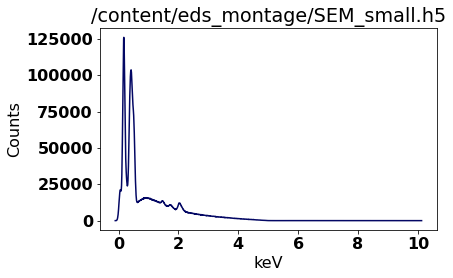

In [6]:
ss = eds_object.get_sum_spectrum()
fig = zoom_plot(x_data=eds_object._Spectroscopic_Values, y_data=ss)
fig, ax = eds_object.plot_sum_spectrum()

(2048, 1)
y_data: (2048,)
x_data: (2048,)


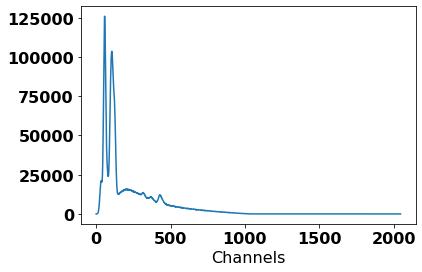

In [7]:
fig, ax = plt.subplots()
ss = eds_object.get_sum_spectrum()

print(ss.reshape((-1,1)).shape)

ax.plot(ss)
ax.set_xlabel('Channels')

fig = zoom_plot(x_data=eds_object._Spectroscopic_Indices, y_data=ss)


In [8]:
print('Preparing to truncate the data.')
start_chan = int(input('Starting channel: '))
num_chan = int(input('Total number of channels: '))

eds_object.trim_spectrally(min_chan=start_chan, max_chan=start_chan + num_chan)
print(eds_object._Spectroscopic_Values[0], eds_object._Spectroscopic_Values[-1])

Preparing to truncate the data.
Starting channel: 400
Total number of channels: 512
1.89 4.445001


In [9]:
def FWHM_shift(E=[], FWHMref=128, Eref=5893):
    """
    FWHM_shift(E=[], FWHMref=128, Eref=5.893):
        E in eV
        FWHM in eV
        FWHMref in eV
    
    This function finds the FWHM for an arbitrary X-ray line on a silicon detector
    if you give it the FWHM reference value and the energy of that reference value.
    
    I.e., to find the width at Oxygen K (525 eV) on a detector with 128 eV FWHM at
    manganese K-alpha,
    FWHM_shift(525, 128, 5893)
        --->returns 54.4 eV
    """
    data_return = np.sqrt( (2.5*(E - Eref) + np.power(FWHMref, 2.0)) )
    return data_return

In [10]:
# Diborides
names    = ['B K', 'C K', 'N K', 'O K', 'Al K',  'Si K', 'Zr La', 'Ti L', 'Ti Ka', 'Ti Kb', 'Mo-L,S-K']
energies = [0.185, 0.2770, 0.392, 0.523, 1.487,   1.74,   2.042,   0.452,   4.51,   4.93,    2.31]
assert len(names) == len(energies), 'names and energies must be the same length.'

# I could get a database and a periodic table clicker, but 
# this is more efficient, really.



widths = (FWHM_shift(np.array(energies)*1000, 130, 5893))/1000  
# assuming ~130 eV resolution for fast maps
# change 130 to detector-specific as needed.

#this is a fudge factor to sharpen the maps' integration windows:
widths = widths # * 0.8

print(widths)

min_energy = eds_object._Spectroscopic_Values.min()
max_energy = eds_object._Spectroscopic_Values.max()

old_energies = energies
energies = []
old_names = names
names = []

#This will remove any element lines that aren't in the truncated energy range
for counter in range( len(old_names) ):  # loop through the lists

    if (old_energies[counter] <= max_energy) & (old_energies[counter] >= min_energy):
        # if energy is in the range, add energy and name to list
        energies.append(old_energies[counter])
        names.append(old_names[counter])

[0.05128353 0.05347897 0.05610258 0.05894913 0.07671375 0.08073103
 0.08527895 0.05742386 0.1159418  0.1203848  0.0891207 ]


In [11]:
print('Preparing to bin data.')
N = int(input('Spatial binning (1, 2, 4, 8, etc.): '))
M = int(input('Spectral binning (1, 2, 4, 8, etc.): '))
M_persistent = M
eds_object.to_sparse()

eds_object.bin_NNM(N=N, M=M)

print(f'Data size: {eds_object._specdata.shape}')

Preparing to bin data.
Spatial binning (1, 2, 4, 8, etc.): 1
Spectral binning (1, 2, 4, 8, etc.): 1
Sparse conversion on /content/eds_montage/SEM_small.h5
Sparse conversion on /content/eds_montage/SEM_small.h5 complete!
Elapsed time 3.0756921768188477.
Binning 1x1 spatial x1 spectral on /content/eds_montage/SEM_small.h5
Binning on /content/eds_montage/SEM_small.h5 complete!
Elapsed time 0.4540414810180664.
Data size: (720896, 512)


Zr La 2.0163582371900834 2.067641762809916
Mo-L,S-K 2.283260516085758 2.336739483914242


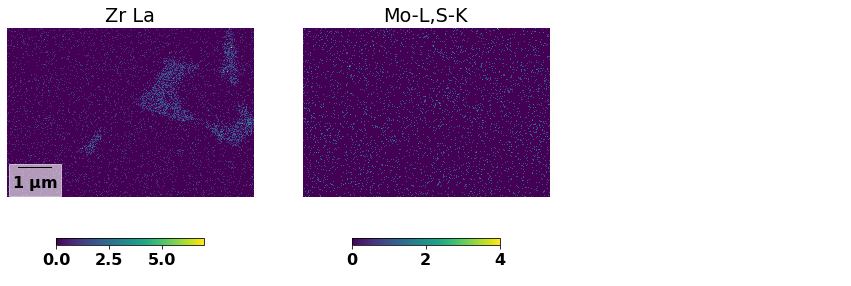

In [12]:
# Extract X-ray maps
# This is simply the traditional X-ray mapping functionality.
NUMX = 3
NUMY = int( np.ceil( len(names) / NUMX))

assert NUMY > 0, 'No X-ray lines in range!'

fig, ax = plt.subplots(nrows=NUMY, ncols=NUMX, figsize=(15,5*NUMY))
ax = ax.flatten()

num = 0
for e, n, w in zip(energies, names, (0.5 * widths)):
    print(f'{n} {e-w} {e+w}')
    idx = (eds_object._Spectroscopic_Values > (e - w)) & (eds_object._Spectroscopic_Values < (e + w))
    M = eds_object._specdata[:, idx].sum(axis=1)
    if eds_object._is_montage == False:
        M = M.reshape((eds_object._nrows, eds_object._ncols))
    else:
        M = EDShandler.deconvolve(M, eds_object._nrows, eds_object._ncols,
                                 eds_object._Panels_X, eds_object._Panels_Y)
    p = ax[num].imshow(M, vmin=0, interpolation='nearest')
    plt.colorbar(p, ax=ax[num], orientation='horizontal', shrink=0.6)
    ax[num].set_title(n)
    ax[num].axis('off')
    if num == 0:
        ax[num] = eds_object._generate_scalebar(ax[num])
    else:
        ax[num].set_axis_off()
    num += 1

for new_num in range(len(energies), NUMY*NUMX):
    ax[new_num].axis('off')


### Scaling is a delicate issue. See the lecture slides for details.

Noise scaling: "both", "spatial", or "spectral": both
Poisson scaling on /content/eds_montage/SEM_small.h5
(1, 720896)
(1, 512)
Any warnings can probably be ignored; NaNs will be sanitized


/content/eds_montage/EDShandler.py:624: RuntimeWarning:

divide by zero encountered in power



Poisson scaling on /content/eds_montage/SEM_small.h5 complete!
Elapsed time 0.2424941062927246.
Performing singular value decomposition with 16 components.
Finished singular value decomposition with 16 components.
Elapsed time 9.512957096099854.


Text(0.5, 0, 'Eigenvector index')

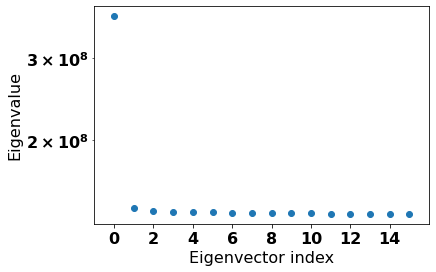

In [13]:
Scaling_phrase = input('Noise scaling: "both", "spatial", or "spectral": ')
eds_object.noise_scale(scaling=Scaling_phrase)


k=16
_, _, _ = eds_object.scaled_svd(k=k, scree=False)
fig, ax = plt.subplots()
ax.semilogy(np.power(eds_object._s_scaled,2), 'o')
ax.set_xlim(left=-1, right=k)
ax.set_xticks(range(0,k,2))
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('Eigenvector index')

### Pull the singular value decomposition.
**USV**^T = **D**

In [14]:
U = eds_object._u_scaled 
S = np.diag(eds_object._s_scaled)
V = eds_object._v_scaled
print(U.shape, S.shape, V.shape)

(720896, 16) (16, 16) (16, 512)


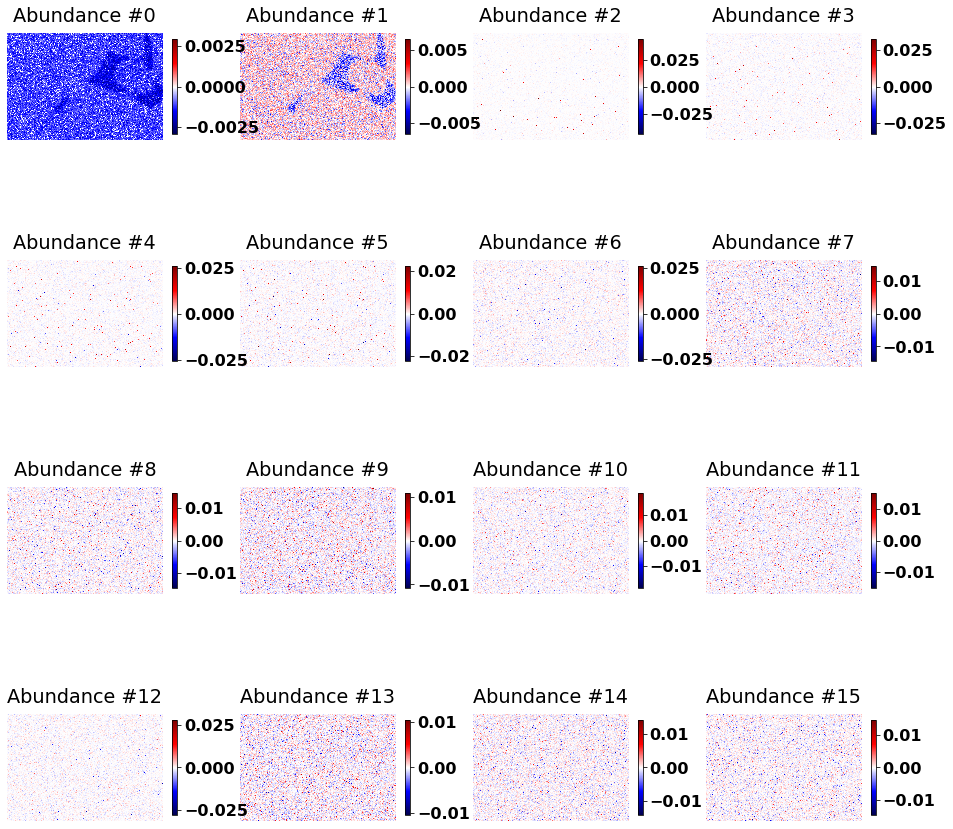

In [15]:
fig, ax = make_figure(k)
ax = ax.flatten()

for i in range(k):
    mM = np.maximum( np.abs(U[:,i].min()), np.abs(U[:,i].max()))
    
    if eds_object._is_montage == True:
        u_hold = EDShandler.deconvolve(U[:,i], eds_object._nrows, eds_object._ncols,
                                      eds_object._Panels_X, eds_object._Panels_Y)
    else:
        u_hold = U[:,i].reshape(eds_object._nrows, eds_object._ncols)
    
    p = ax[i].matshow(u_hold, 
                      vmin=-mM, vmax=mM, cmap='seismic')
    plt.colorbar(p, ax=ax[i], shrink=0.5)
    ax[i].axis('off')
    ax[i].set_title(f'Abundance #{i}')


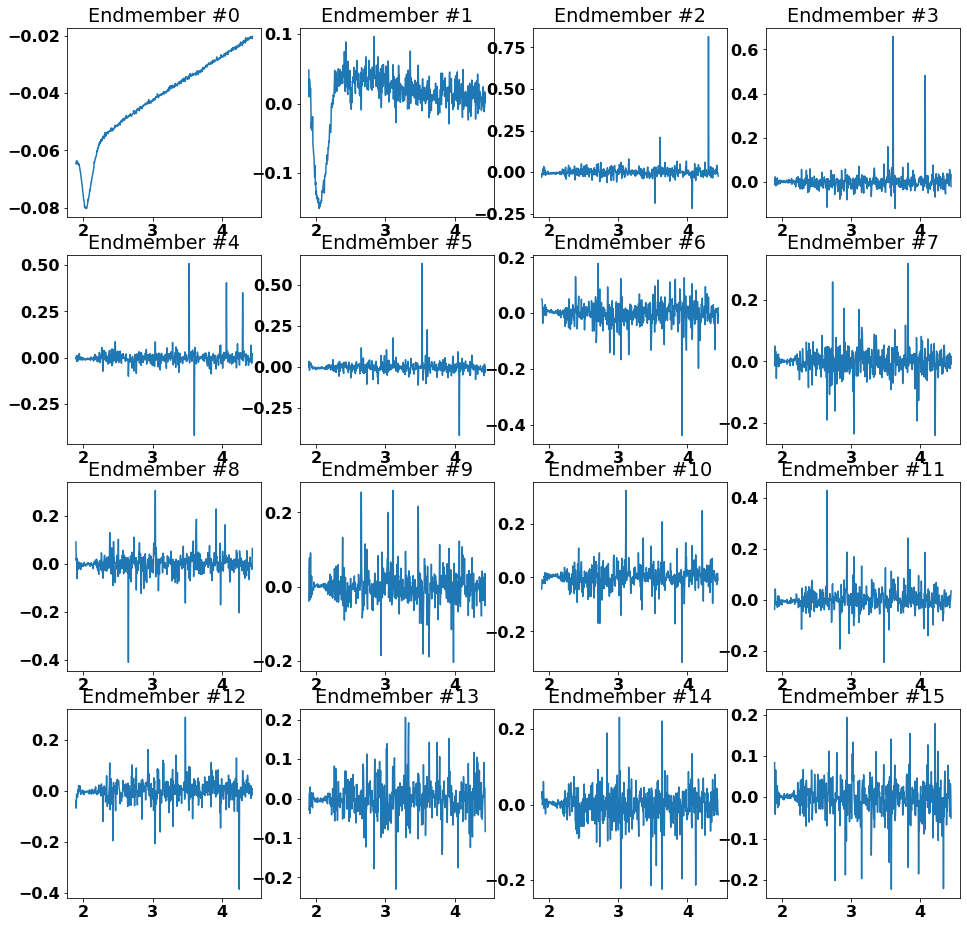

In [16]:
fig, ax = make_figure(k)
ax = ax.flatten()
xaxis = eds_object._Spectroscopic_Values

for i in range(k):
    ax[i].plot(xaxis, V[i,:])
    ax[i].set_title(f'Endmember #{i}')

### Truncate the model. 
`U @ S @V.T` is the poisson-scaled; `T @ P.T` is returned to real space and re-orthogonalized (See Keenan 2007 for re-orthogonalization.)

In [19]:
trunc = int(input('Truncate model to rank :'))

U, S, V = eds_object.get_truncated_model(scaled=True, trunc=trunc)
T, P = eds_object.get_truncated_model(scaled=False, trunc=trunc)
L = U @ np.diag(S)  # The 'L'eft side of the singular value decomposition
print(L.shape)
D_tilde = T @ P.T
print(D_tilde.shape)

Truncate model to rank :8
(720896, 8)
(720896, 512)


IndexError: ignored

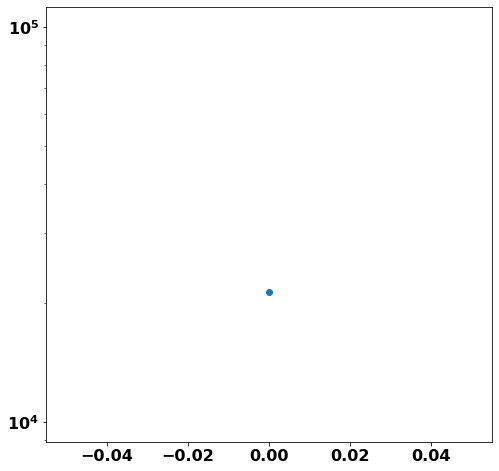

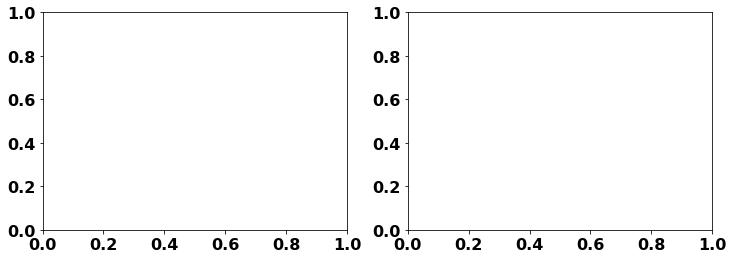

In [20]:
T, P, trace = arb_scree(T, P)

fig,ax = plt.subplots(figsize=(8,8))
ax.semilogy(trace, 'o')
fig, ax = plot_together(eds_object, T=T, P=P, cmap='twilight', pownorm=[])
fig.suptitle('Re-orthogonalized PCA')

In [ ]:
fig = zoom_plot(x_data=eds_object._Spectroscopic_Values, y_data=P.T, energies=energies, names=names)

In [ ]:
fig, ax = plot_compare(eds_object, P, "fPCA results" )

In [ ]:
Pss, Rp = varimax(P)
Tss = T @ Rp

In [ ]:
Tss, Pss = normalize_endmembers(Tss, Pss)
Tss, Pss, trace = arb_scree(Tss, Pss)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.semilogy(trace,'o')
plot_together(eds_object, T=Tss, P=Pss, title_string='Spectral simplicity after PCA', cmap='twilight',
             pownorm=[]);

In [ ]:
fig = zoom_plot(x_data=eds_object._Spectroscopic_Values, y_data=Pss.T, energies=energies, names=names)

In [ ]:
fig, ax = plot_compare(eds_object, Pss, "Spectral simplicity results" )

In [ ]:
Tnorm = np.zeros(T.shape)
Pnorm = np.zeros(P.shape)

for i in range(trunc):
    fact = np.sqrt(np.dot(T[:, i].T, T[:, i]))
    Tnorm[:, i] = T[:, i].flatten() / fact
    Pnorm[:, i] = ((P[:, i].flatten()).T * fact).flatten()
    
Tspat, Rspat = varimax(Tnorm)
Pspat = (np.linalg.inv(Rspat) @ Pnorm.T).T

In [ ]:
Tspat, Pspat = flip_positive(Tspat, Pspat)
Tspat, Pspat = normalize_endmembers(Tspat, Pspat)

Tspat, Pspat, trace = arb_scree(Tspat, Pspat)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.semilogy(trace,'o')

plot_together(eds_object, T=Tspat, P=Pspat, title_string='Spatial Simplicity after PCA', cmap='twilight',
             pownorm=[]);


In [ ]:
fig = zoom_plot(x_data=eds_object._Spectroscopic_Values, y_data=Pspat.T, energies=energies, 
                names=names, marker_color='rgba(0, 0, 0, 0.5)',
               width=1.2, offset_factor=0.2)

In [ ]:
fig, ax = plot_compare(eds_object, Pspat, "Spatial simplicity results" )